In [1]:
import math, sys, functools, os, codecs
from glob import glob
import sqlite3
import numpy as np
import numpy.random as rd
from numpy import matrix
import pandas as pd
import scipy as sp
from scipy import stats as st
from datetime import  datetime as dt
from collections import Counter
from itertools import chain
import multiprocessing as mp

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation as ani

import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline

font_path = '/Library/Fonts/Osaka.ttf'

font_prop = matplotlib.font_manager.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

import  pickle
def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)

from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['lightblue', 'mediumblue', 'mediumblue','black', 'red', 'red', 'orangered'])

from matplotlib import font_manager

# for Mac
font_path = '/Library/Fonts/Osaka.ttf'
font_prop = font_manager.FontProperties(fname=font_path)

In [102]:
# 50個の正規分布にし違う乱数を　5000回生成する

n_data = 30
n_trial = 5000
def gen_rand_norm(n_data, n_trial, gen_rand = st.norm.rvs, pdf = st.norm.pdf):
    m = np.zeros((n_trial, n_data))
    for i in range(n_trial):
        x   = st.norm.rvs(loc=0, scale=1, size=n_data)
        x.sort()  # xを昇順でソートする。（順序統計量とする）
        m[i] = x
    return m


def gen_rand_gamma(n_data, n_trial, gen_rand = st.norm.rvs, pdf = st.norm.pdf):
    m = np.zeros((n_trial, n_data))
    for i in range(n_trial):
        x   = st.gamma.rvs(a=3, loc=0, scale=1, size=n_data)
        x.sort()  # xを昇順でソートする。（順序統計量とする）
        m[i] = x
    return m


/Users/matsuken/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


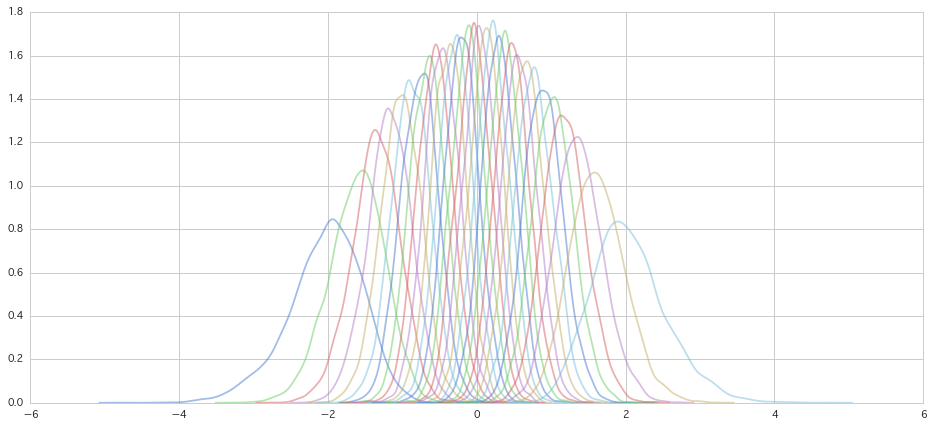

In [103]:
m = gen_rand_norm(n_data, n_trial)

xx = np.linspace(-5, 5, 501)
plt.figure(figsize=(16,7))
for i in range(n_data):
    # m[:,i] => i 番目の順序統計量の n_trial 回分のサンプル。
    # これをもとに密度推定した結果を描画。
    sns.kdeplot(m[:,i], alpha=0.5)

/Users/matsuken/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


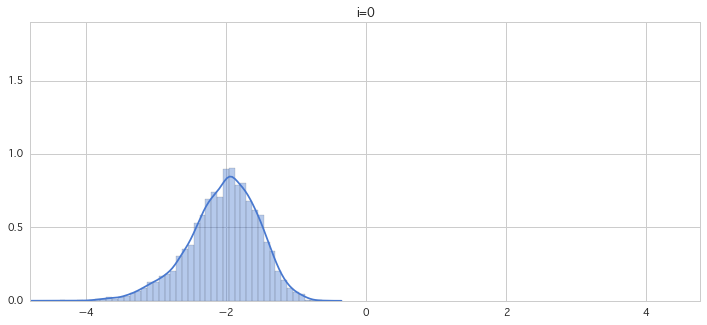

In [104]:
def animate(nframe):
    global num_frame, xx, m
    plt.clf()
    plt.xlim(np.min(m), np.max(m))
    plt.ylim(0, 1.9)
    # m[:,i] => i 番目の順序統計量の n_trial 回分のサンプル。
    # これをもとに密度推定した結果を描画。
    sns.distplot(m[:,int(nframe)])
    plt.title("i={}".format(nframe))
    
num_frame = n_data

fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=num_frame, blit=False)
anim.save('ordered_norm.gif', writer='imagemagick', fps=5, dpi=64)

/Users/matsuken/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


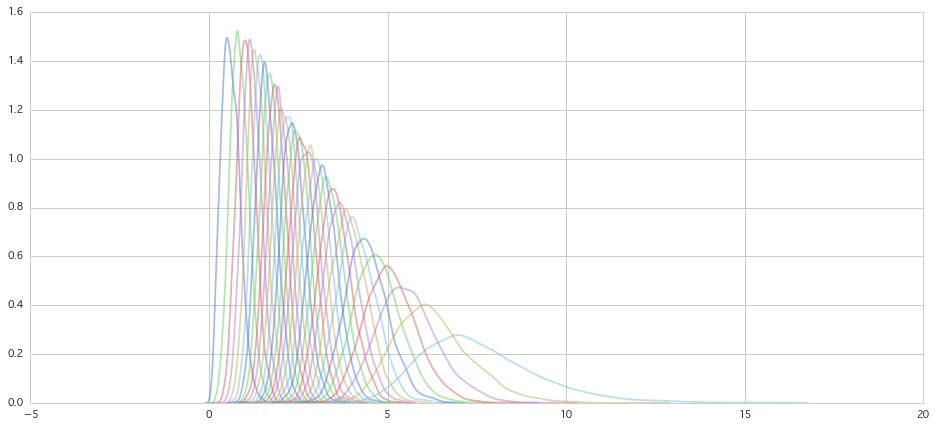

In [105]:
m = gen_rand_gamma(n_data, n_trial)

xx = np.linspace(-5, 5, 501)
plt.figure(figsize=(16,7))
for i in range(n_data):
    # m[:,i] => i 番目の順序統計量の n_trial 回分のサンプル。
    # これをもとに密度推定した結果を描画。
    sns.kdeplot(m[:,i], alpha=0.5)

/Users/matsuken/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


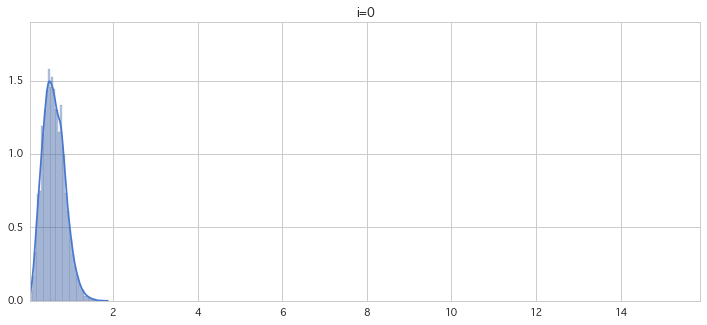

In [106]:
def animate(nframe):
    global num_frame, xx, m
    plt.clf()
    plt.xlim(np.min(m), np.max(m))
    plt.ylim(0, 1.9)
    # m[:,i] => i 番目の順序統計量の n_trial 回分のサンプル。
    # これをもとに密度推定した結果を描画。
    sns.distplot(m[:,int(nframe)])
    plt.title("i={}".format(nframe))
    
num_frame = n_data

fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=num_frame, blit=False)
anim.save('ordered_dist_gamma.gif', writer='imagemagick', fps=5, dpi=64)

順序統計量の分布（一般の場合）
いま $X_1, X_2, \cdots, X_n$ は 無作為抽出での標本であるとする。すなわち、同一分布に従い、互いに独立 である（i.i.d.）とする。さらに、これらは連続分布を持つ確率変数であり、$f(x)$ がその確率密度関数、$F(x)$が累積分布関数とする。また、これらを小さい順に並べた順序統計量を$X(1), X(2),\cdots, X(n)$ とする。この時、$k$ 番目の順序統計量$X(k)$の累積分布関数は次で与えられる。
$$
{\displaystyle F_{X_{(k)}}(x)=\sum _{j=k}^{n}{\binom {n}{j}}F(x)^{j}(1-F(x))^{n-j}} 
$$
また、その確率密度関数は
$$
{\displaystyle f_{X_{(k)}}(x)={\frac {n!}{(k-1)!(n-k)!}}F(x)^{k-1}(1-F(x))^{n-k}f(x)} 
$$
となる。

Wikipediaより (https://ja.wikipedia.org/wiki/%E9%A0%86%E5%BA%8F%E7%B5%B1%E8%A8%88%E9%87%8F)

In [77]:
from scipy.misc import comb as comb
def order_density_stdnorm(x, n, k):
    """
    x: 密度関数の対象となるxの値 
    n: データの個数
    k: k番目のデータ
    """
    return comb(n, k)*k*st.norm.cdf(x, loc=0, scale=1)**(k-1)*\
           (1-st.norm.cdf(x, loc=0, scale=1))**(n-k)*st.norm.pdf(x, loc=0, scale=1)

def order_density_gamma(x, n, k):
    """
    x: 密度関数の対象となるxの値 
    n: データの個数
    k: k番目のデータ
    """
    return comb(n, k)*k*st.gamma.cdf(x, a=3, loc=0, scale=1)**(k-1)*\
           (1-st.gamma.cdf(x, a=3, loc=0, scale=1))**(n-k)*st.gamma.pdf(x, a=3, loc=0, scale=1)

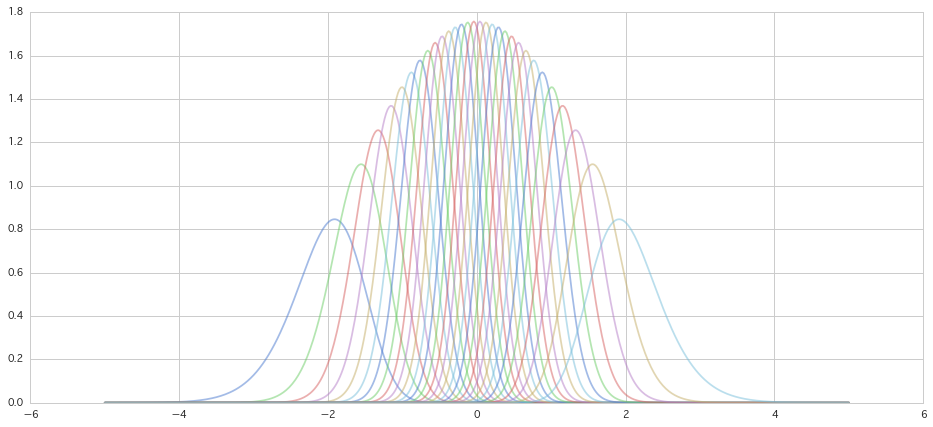

In [78]:
plt.figure(figsize=(16,7))
xx = np.linspace(-5, 5, 501)
y = np.empty((n_data, 501))
y_cum = np.zeros(501)
for i in range(n_data):
    y[i] = order_density_stdnorm(xx, n_data, i+1)
    plt.plot(xx, y[i], alpha=0.5)
    y_cum += y[i]

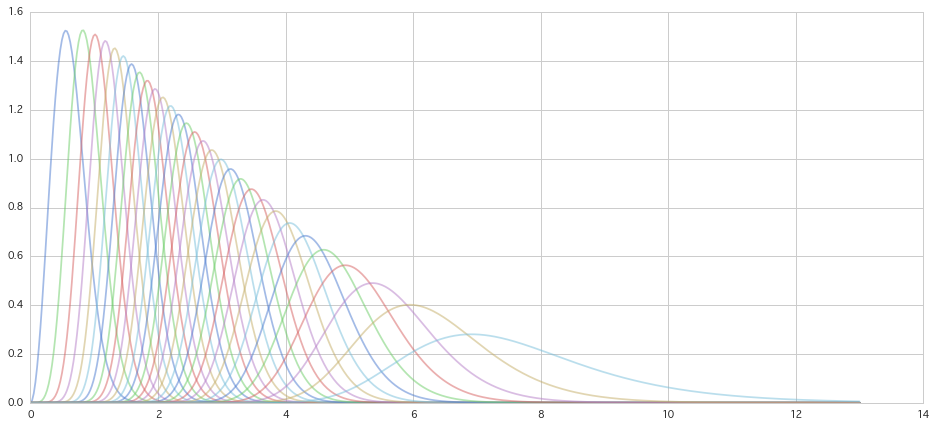

In [79]:
plt.figure(figsize=(16,7))
xx = np.linspace(0, 13, 501)
y = np.empty((n_data, 501))
y_cum = np.zeros(501)
for i in range(n_data):
    y[i] = order_density_gamma(xx, n_data, i+1)
    plt.plot(xx, y[i], alpha=0.5)
    y_cum += y[i]

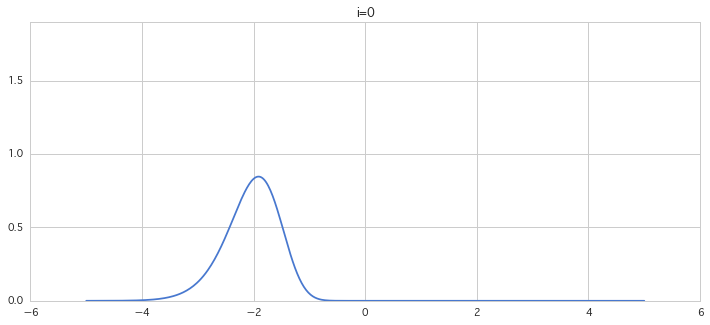

In [65]:
def animate(nframe):
    global num_frame, xx
    plt.clf()
    plt.xlim(-6, 6)
    plt.ylim(0, 1.9)
    plt.plot(xx, y[nframe])
    plt.title("i={}".format(nframe))

num_frame = n_data
xx = np.linspace(-5, 5, 501)

fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=num_frame, blit=False)
anim.save('ordered_pdf.gif', writer='imagemagick', fps=5, dpi=64)